
## Learning a sine wave with Transformers


In [1]:


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler


In [2]:


# === Sine overwrite function ===
def overwrite_with_sine(df):
    N = len(df)
    t = np.linspace(0, 4 * np.pi, N)
    sine = np.sin(t)
    df.iloc[:, 2] = sine  # SI
    df.iloc[:, 5] = np.roll(sine, 1)
    df.iloc[:, 8] = 2 * sine
    df.iloc[:, 10] = np.cos(t)
    return df


In [3]:

# === Sequence dataset ===
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.x = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.x.append(data[i:i+seq_len   ])
            self.y.append(data[  i+seq_len, 2])  # Target = SI
        self.x = torch.tensor(np.stack(self.x), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [4]:

class TinyGPT(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, nhead=1, nlayers=1):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(emb_dim, 1)

    def forward(self, x):
        x = self.in_proj(x) + self.pos_emb
        x = self.transformer(x)
        return self.out_proj(x[:, -1]).squeeze(-1)



## Main


In [5]:

## df = pd.DataFrame(np.random.randn(1300, 35))

## train_and_plot("datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv")

df = pd.read_csv('datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv')

df


,Unnamed: 0,delta_SI,mov_avg_SI,SI_f1,Date_Map,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,...,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,Taphole_f2,HOT_METAL_TEMP_f3,cokerate_f4
0,0,0.000000,0.000000,0.719500,2022-01-01 00:45:00,4.242439,2161.425209,9306.840913,184.818611,0.0,...,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,1.0,2730.002686,884.0
1,1,0.000000,0.000000,0.710486,2022-01-01 08:43:00,4.174343,2168.238915,9336.364456,185.993447,0.0,...,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,1.0,2730.002686,884.0
2,2,-0.044380,0.000000,0.666106,2022-01-01 10:17:00,4.126144,2167.779119,9419.200115,185.828474,0.0,...,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,3.0,2729.690821,884.0
3,3,0.009040,0.000000,0.675145,2022-01-01 12:40:00,4.120736,2166.974740,9564.165802,185.924481,0.0,...,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,1.0,2703.051419,884.0
4,4,0.101686,0.000000,0.776831,2022-01-01 15:06:00,4.120331,2166.384674,9648.247637,185.942943,0.0,...,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,3.0,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,1389,0.109500,0.004444,0.762500,2021-12-31 13:10:00,4.204430,2169.361647,9297.484543,185.046491,0.0,...,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,3.0,2730.002686,884.0
1390,1390,-0.116500,0.008900,0.646000,2021-12-31 14:41:00,4.208539,2169.079601,9312.779010,185.053796,0.0,...,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,1.0,2730.002686,884.0
1391,1391,0.008667,-0.037618,0.654667,2021-12-31 16:15:00,4.212648,2168.797556,9303.753420,185.007919,0.0,...,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,3.0,2730.002686,884.0
1392,1392,-0.063000,-0.014340,0.591667,2021-12-31 17:40:00,4.217784,2168.444999,9333.448101,184.942435,0.0,...,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,1.0,2730.002686,884.0


In [6]:

df = df.drop(["Unnamed: 0", "Date_Map"], axis=1)
df


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,sec,min,...,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,Taphole_f2,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0,45,...,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,1.0,2730.002686,884.0
1,0.000000,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0,43,...,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,1.0,2730.002686,884.0
2,-0.044380,0.000000,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0,17,...,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,3.0,2729.690821,884.0
3,0.009040,0.000000,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0,40,...,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,1.0,2703.051419,884.0
4,0.101686,0.000000,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0,6,...,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,3.0,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,0.109500,0.004444,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0,10,...,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,3.0,2730.002686,884.0
1390,-0.116500,0.008900,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0,41,...,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,1.0,2730.002686,884.0
1391,0.008667,-0.037618,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0,15,...,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,3.0,2730.002686,884.0
1392,-0.063000,-0.014340,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0,40,...,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,1.0,2730.002686,884.0


In [7]:

df = df.select_dtypes(include=[np.number]).dropna(axis=1)
df


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,sec,min,...,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,Taphole_f2,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0,45,...,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,1.0,2730.002686,884.0
1,0.000000,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0,43,...,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,1.0,2730.002686,884.0
2,-0.044380,0.000000,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0,17,...,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,3.0,2729.690821,884.0
3,0.009040,0.000000,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0,40,...,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,1.0,2703.051419,884.0
4,0.101686,0.000000,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0,6,...,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,3.0,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,0.109500,0.004444,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0,10,...,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,3.0,2730.002686,884.0
1390,-0.116500,0.008900,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0,41,...,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,1.0,2730.002686,884.0
1391,0.008667,-0.037618,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0,15,...,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,3.0,2730.002686,884.0
1392,-0.063000,-0.014340,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0,40,...,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,1.0,2730.002686,884.0


In [8]:


df = overwrite_with_sine(df)
df


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,sec,min,...,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,Taphole_f2,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.000000,0.000000e+00,4.242439,2161.425209,-4.898587e-16,184.818611,0.0,0.000000e+00,45,...,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,1.0,2730.002686,884.0
1,0.000000,0.000000,9.020962e-03,4.174343,2168.238915,0.000000e+00,185.993447,0.0,1.804192e-02,43,...,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,1.0,2730.002686,884.0
2,-0.044380,0.000000,1.804119e-02,4.126144,2167.779119,9.020962e-03,185.828474,0.0,3.608238e-02,17,...,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,3.0,2729.690821,884.0
3,0.009040,0.000000,2.705995e-02,4.120736,2166.974740,1.804119e-02,185.924481,0.0,5.411990e-02,40,...,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,1.0,2703.051419,884.0
4,0.101686,0.000000,3.607651e-02,4.120331,2166.384674,2.705995e-02,185.942943,0.0,7.215301e-02,6,...,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,3.0,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,0.109500,0.004444,-3.607651e-02,4.204430,2169.361647,-4.509013e-02,185.046491,0.0,-7.215301e-02,10,...,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,3.0,2730.002686,884.0
1390,-0.116500,0.008900,-2.705995e-02,4.208539,2169.079601,-3.607651e-02,185.053796,0.0,-5.411990e-02,41,...,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,1.0,2730.002686,884.0
1391,0.008667,-0.037618,-1.804119e-02,4.212648,2168.797556,-2.705995e-02,185.007919,0.0,-3.608238e-02,15,...,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,3.0,2730.002686,884.0
1392,-0.063000,-0.014340,-9.020962e-03,4.217784,2168.444999,-1.804119e-02,184.942435,0.0,-1.804192e-02,40,...,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,1.0,2730.002686,884.0


In [9]:

scaler = StandardScaler()
scaled = scaler.fit_transform( df.values )

type(scaled)


numpy.ndarray

In [10]:

seq_len = 10
ds      = SequenceDataset(scaled, seq_len)
loader  = DataLoader(ds, batch_size=64, shuffle=True)


In [11]:

print( scaled.shape[1] )


35


In [12]:

model     = TinyGPT(input_dim=scaled.shape[1], emb_dim=32, seq_len=seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()


In [13]:

EPOCHS = 20

for epoch in range(EPOCHS):
    for xb, yb in loader:
        pred = model(xb)
        
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [15]:

model.eval()
with torch.no_grad():
    all_x = torch.tensor(ds.x, dtype=torch.float32)
    all_y = ds.y
    preds = model(all_x)


/Users/user/opt/anaconda3/envs/py37_Transfer_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


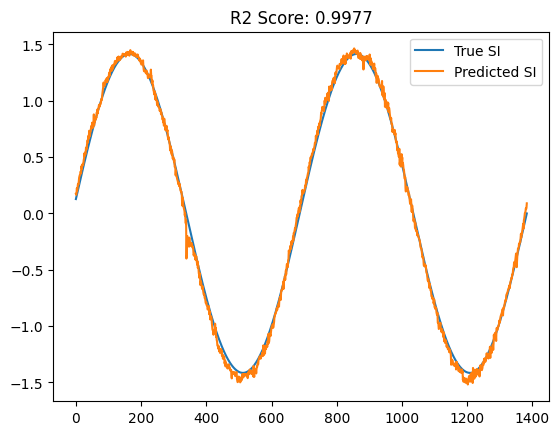

In [16]:

r2 = r2_score(all_y.numpy(), preds.numpy())
plt.plot(all_y.numpy(), label="True SI")
plt.plot(preds.numpy(), label="Predicted SI")
plt.title(f"R2 Score: {r2:.4f}")
plt.legend()
plt.show()



## other


In [ ]:


# Author: Ricardo A. Calix, Ph.D.
# Complete Time Series GPT for Synthetic Sine Wave Data

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# Set seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Data Handling ====

def generate_sine_wave_data(seq_len=10, total=1500):
    t = np.linspace(0, 8 * np.pi, total)
    si = np.sin(t)
    df = pd.DataFrame(np.zeros((total, 35)), columns=[f'f{i}' for i in range(35)])
    df.iloc[:, 2] = si
    df.iloc[:, 5] = np.roll(si, 1)
    df.iloc[:, 8] = 2 * si
    df.iloc[:, 10] = np.cos(t)
    return df

def make_dataset(df, seq_len=10):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return torch.stack(x), torch.stack(y)

# ==== Model ====

class SimpleGPT(nn.Module):
    def __init__(self, input_dim=34, emb_dim=64, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, 10, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)
        self.si_head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.in_proj(x) + self.pos_emb
        h = self.transformer(x)
        out = self.out_proj(h)
        si = self.si_head(h)
        return out, si

    @torch.no_grad()
    def generate(self, idx, steps=9):
        self.eval()
        preds = []
        for _ in range(steps):
            out, si = self(idx[:, -10:, :])
            next_step = out[:, -1:, :].clone()
            next_step[:, :, 2] = si[:, -1:, 0]
            idx = torch.cat([idx, next_step], dim=1)
            preds.append(si[:, -1])
        return torch.cat(preds, dim=1)

# ==== Training ====

def train_model(csv_file=None):
    if csv_file:
        df = pd.read_csv(csv_file).dropna().iloc[:, :-2]
    else:
        df = generate_sine_wave_data()

    seq_len = 10
    
  
    df = df.select_dtypes(include=[np.number])  # Remove non-numeric
    df = df.dropna()                            # Remove NaNs

   
    x, y = make_dataset(df, seq_len)
    x, y = x.to(device), y.to(device)
    loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)

    model = SimpleGPT().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(20):
        for xb, yb in loader:
            out, si = model(xb)
            loss = criterion(out[:, -1], yb) + criterion(si[:, -1, 0], yb[:, 2])
            opt.zero_grad()
            loss.backward()
            opt.step()

    return model, df, seq_len

# ==== Evaluation ====

def evaluate(model, df, seq_len):
    data = torch.tensor(df.values, dtype=torch.float32).to(device)
    context = data[:seq_len].unsqueeze(0)
    preds = model.generate(context, steps=len(data) - seq_len)
    preds = preds.cpu().numpy().flatten()
    target = df.iloc[seq_len:, 2].values
    r2 = r2_score(target, preds)

    plt.plot(target, label='True SI')
    plt.plot(preds, label='Predicted SI')
    plt.title(f'R2 Score: {r2:.4f}')
    plt.legend()
    plt.show()

# ==== Run ====

if __name__ == "__main__":
    model, df, seq_len = train_model( 'datesBrokenUp_MovingAVG_FINAL_DATA_rcalix.csv' )
    evaluate(model, df, seq_len)




## other


Epoch 1: Loss 4.0765
Epoch 2: Loss 1.6312
Epoch 3: Loss 1.2547
Epoch 4: Loss 1.1393
Epoch 5: Loss 1.0777
Epoch 6: Loss 1.0013
Epoch 7: Loss 0.9838
Epoch 8: Loss 0.9648
Epoch 9: Loss 0.9490
Epoch 10: Loss 0.9450
Epoch 11: Loss 0.9380
Epoch 12: Loss 0.9214
Epoch 13: Loss 0.9077
Epoch 14: Loss 0.9175
Epoch 15: Loss 0.9154
Epoch 16: Loss 0.8963
Epoch 17: Loss 0.9291
Epoch 18: Loss 0.9220
Epoch 19: Loss 0.8870
Epoch 20: Loss 0.8798


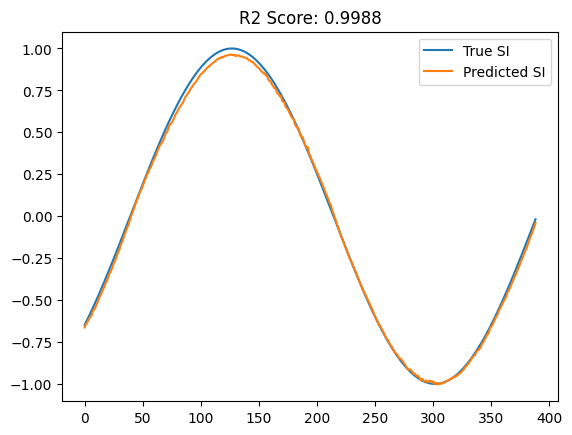

In [17]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# === Generate synthetic sine dataset with 35 features ===
def generate_sine_dataframe(length=1400):
    t = np.linspace(0, 8 * np.pi, length)
    sine = np.sin(t)
    df = pd.DataFrame(np.zeros((length, 35)), columns=[f"f{i}" for i in range(35)])
    df.iloc[:, 2] = sine
    df.iloc[:, 5] = np.roll(sine, 1)
    df.iloc[:, 8] = 2 * sine
    df.iloc[:, 10] = np.cos(t)
    df.iloc[:, 12] = 0.5 * sine + 0.5 * np.roll(sine, 1)
    df.iloc[:, 15] = np.sin(t + np.pi / 4)
    df.iloc[:, 18] = sine + np.random.normal(0, 0.01, len(df))
    df.iloc[:, 20] = np.sqrt(np.abs(sine)) * np.sign(sine)
    df.iloc[:, 25] = np.random.normal(0, 1.0, len(df))
    return df.astype(np.float32)

# === Build sequences of input/output pairs ===
def make_dataset(df, seq_len=10, pred_len=1):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len, :])  # full vector prediction
    return torch.stack(x), torch.stack(y)

# === Transformer model ===
class GPTTimeSeries(nn.Module):
    def __init__(self, input_dim=35, emb_dim=64, seq_len=10):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.out_proj = nn.Linear(emb_dim, input_dim)  # predict full vector

    def forward(self, x):
        B, T, F = x.shape
        x = self.in_proj(x) + self.pos_emb
        h = self.encoder(x)
        return self.out_proj(h[:, -1:, :])  # Predict next token only

# === Main training and plotting ===
def train_and_evaluate():
    # Hyperparams
    seq_len = 10
    pred_len = 1
    batch_size = 32
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data
    df = generate_sine_dataframe(1400)
    x, y = make_dataset(df, seq_len, pred_len)
    x_train, y_train = x[:1000], y[:1000]
    x_test, y_test = x[1000:], y[1000:]

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    # Model
    model = GPTTimeSeries(input_dim=35, emb_dim=64, seq_len=seq_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(x_test.to(device)).squeeze(1).cpu().numpy()
        actual = y_test.squeeze(1).cpu().numpy()

    # Plot: only SI (column 2)
    real_si = actual[:, 2]
    pred_si = preds[:, 2]
    r2 = r2_score(real_si, pred_si)

    plt.plot(real_si, label="True SI")
    plt.plot(pred_si, label="Predicted SI")
    plt.title(f"R2 Score: {r2:.4f}")
    plt.legend()
    plt.show()

# Run it
train_and_evaluate()




## yet another


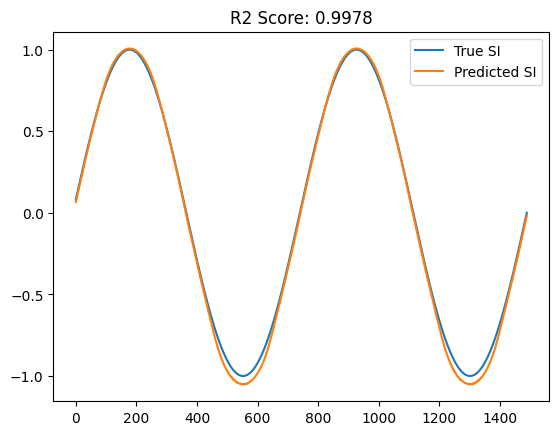

In [20]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ====== Synthetic Dataset with Sine Pattern ======
def generate_sine_dataset(num_points=1500, num_features=5):
    t = np.linspace(0, 4 * np.pi, num_points)
    target = np.sin(t)

    data = np.zeros((num_points, num_features))
    data[:, 0] = target                             # true target
    data[:, 1] = np.roll(target, 1)                 # lag 1
    data[:, 2] = 2 * target                         # scaled
    data[:, 3] = np.cos(t)                          # cosine
    data[:, 4] = target + np.random.normal(0, 0.01, size=num_points)  # noisy

    return torch.tensor(data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

# ====== Make Sequence Dataset ======
def make_dataset(data, target, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return torch.stack(x), torch.stack(y)

# ====== Transformer Model ======
class SimpleGPT(nn.Module):
    def __init__(self, input_dim, emb_dim=64, nhead=4, num_layers=2, max_len=1000):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(emb_dim, 1)

    def forward(self, x):  # x: [B, T, F]
        x = self.in_proj(x) + self.pos_emb[:, :x.size(1)]
        h = self.transformer(x)
        return self.out_proj(h[:, -1]).squeeze(-1)  # use last token

# ====== Train Function ======
def train_model(seq_len=10, epochs=20):
    raw_x, raw_y = generate_sine_dataset()
    x, y = make_dataset(raw_x, raw_y, seq_len)

    model = SimpleGPT(input_dim=5).to(device)
    loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model, x.to(device), y.to(device)

# ====== Evaluation and Plotting ======
def evaluate_and_plot(model, x, y):
    model.eval()
    with torch.no_grad():
        preds = model(x).cpu().numpy()
    true = y.cpu().numpy()
    r2 = r2_score(true, preds)

    plt.plot(true, label="True SI")
    plt.plot(preds, label="Predicted SI")
    plt.title(f"R2 Score: {r2:.4f}")
    plt.legend()
    plt.show()

    return r2

# ====== Run Everything ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, x, y = train_model()
r2 = evaluate_and_plot(model, x, y)




## ohter


Epoch 1, Loss: 0.1923
Epoch 2, Loss: 0.0110
Epoch 3, Loss: 0.0042
Epoch 4, Loss: 0.0037
Epoch 5, Loss: 0.0033
Epoch 6, Loss: 0.0032
Epoch 7, Loss: 0.0032
Epoch 8, Loss: 0.0029
Epoch 9, Loss: 0.0026
Epoch 10, Loss: 0.0023
Epoch 11, Loss: 0.0026
Epoch 12, Loss: 0.0023
Epoch 13, Loss: 0.0024
Epoch 14, Loss: 0.0025
Epoch 15, Loss: 0.0020
Epoch 16, Loss: 0.0019
Epoch 17, Loss: 0.0017
Epoch 18, Loss: 0.0018
Epoch 19, Loss: 0.0019
Epoch 20, Loss: 0.0017


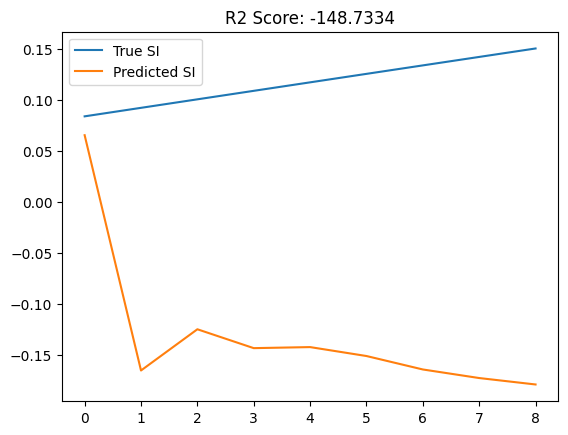

In [21]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ===== Sine dataset generator with SI in column 2 =====
def generate_sine_df(n_samples=1500, n_features=5):
    t = np.linspace(0, 4 * np.pi, n_samples)
    sine = np.sin(t)
    df = pd.DataFrame(np.random.randn(n_samples, n_features) * 0.05)
    df.iloc[:, 2] = sine  # column 2 is SI
    df.iloc[:, 3] = np.roll(sine, 1)  # lagged
    df.iloc[:, 4] = 0.5 * sine + 0.5 * np.roll(sine, 1)
    return df

# ===== Dataset handling =====
def make_dataset(df, seq_len=10):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len - 9):  # leave room for 9 predictions
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+9, 2])  # 9 future SI values only
    return torch.stack(x), torch.stack(y)

# ===== Model =====
class TinyGPT(nn.Module):
    def __init__(self, input_dim=5, emb_dim=64, n_heads=4, n_layers=2, seq_len=10):
        super().__init__()
        self.seq_len = seq_len
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)  # predict full vector
        self.head_si = nn.Linear(input_dim, 1)         # extract SI

    def forward(self, x):  # x: [B, T, F]
        x = self.in_proj(x) + self.pos_emb[:, :x.size(1)]
        h = self.transformer(x)
        return self.out_proj(h)  # [B, T, F]

    @torch.no_grad()
    def generate(self, x, steps):
        self.eval()
        preds = []
        for _ in range(steps):
            x_slice = x[:, -self.seq_len:]
            out = self.forward(x_slice)
            next_vec = out[:, -1:, :]  # [B, 1, F]
            preds.append(self.head_si(next_vec).squeeze(-1))  # just SI
            x = torch.cat([x, next_vec], dim=1)
        return torch.cat(preds, dim=1)  # [B, steps]

# ===== Training and evaluation =====
def train_model():
    df = generate_sine_df()
    x, y = make_dataset(df)
    train_loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)

    model = TinyGPT()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(20):
        total_loss = 0
        for xb, yb in train_loader:
            out = model(xb)
            si_preds = model.head_si(out[:, -1, :])  # last token -> predict SI
            loss = criterion(si_preds.squeeze(-1), yb[:, 0])  # just first of 9
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluate autoregressive generation
    model.eval()
    x_test = x[:1]  # use 1 sample
    y_test = y[0].numpy()
    with torch.no_grad():
        y_pred = model.generate(x_test, steps=9).squeeze().numpy()

    r2 = r2_score(y_test, y_pred)
    plt.plot(y_test, label='True SI')
    plt.plot(y_pred, label='Predicted SI')
    plt.title(f"R2 Score: {r2:.4f}")
    plt.legend()
    plt.show()

if __name__ == '__main__':
    train_model()




## other 


Epoch 1: Loss = 7.4323, p=0.50
Epoch 2: Loss = 1.0090, p=0.49
Epoch 3: Loss = 0.7561, p=0.47
Epoch 4: Loss = 0.6531, p=0.46
Epoch 5: Loss = 0.5928, p=0.45
Epoch 6: Loss = 0.5231, p=0.44
Epoch 7: Loss = 0.4759, p=0.42
Epoch 8: Loss = 0.4484, p=0.41
Epoch 9: Loss = 0.4232, p=0.40
Epoch 10: Loss = 0.4229, p=0.39
Epoch 11: Loss = 0.4778, p=0.38
Epoch 12: Loss = 0.4392, p=0.36
Epoch 13: Loss = 0.5653, p=0.35
Epoch 14: Loss = 0.5068, p=0.34
Epoch 15: Loss = 0.4113, p=0.33
Epoch 16: Loss = 0.3992, p=0.31
Epoch 17: Loss = 0.4682, p=0.30
Epoch 18: Loss = 0.4139, p=0.29
Epoch 19: Loss = 0.4134, p=0.28
Epoch 20: Loss = 0.3984, p=0.26
Epoch 21: Loss = 0.5100, p=0.25
Epoch 22: Loss = 0.4003, p=0.24
Epoch 23: Loss = 0.3947, p=0.22
Epoch 24: Loss = 0.3790, p=0.21
Epoch 25: Loss = 0.3744, p=0.20
Epoch 26: Loss = 0.3719, p=0.19
Epoch 27: Loss = 0.3568, p=0.17
Epoch 28: Loss = 0.3822, p=0.16
Epoch 29: Loss = 0.3790, p=0.15
Epoch 30: Loss = 0.4088, p=0.14
Epoch 31: Loss = 0.3831, p=0.12
Epoch 32: Loss = 

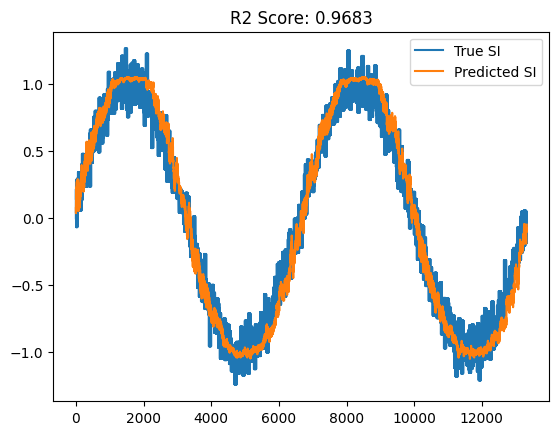

In [22]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# === Synthetic Dataset ===
def make_sine_data(n_samples=1500, n_features=5):
    t = np.linspace(0, 4 * np.pi, n_samples)
    si = np.sin(t) + 0.1 * np.random.randn(n_samples)  # Target column
    data = np.zeros((n_samples, n_features))
    data[:, 0] = si
    for i in range(1, n_features):
        data[:, i] = np.roll(si, i) + 0.01 * np.random.randn(n_samples)
    return pd.DataFrame(data)

# === Dataset Preparation ===
def make_dataset(df, seq_len=10):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len - 9):  # 9-step prediction
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+9, 0])  # Next 9 SI values
    return torch.stack(x), torch.stack(y)

# === Transformer Model ===
class TinyGPT(nn.Module):
    def __init__(self, input_dim, model_dim=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, model_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, 1000, model_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(model_dim, 1)  # Predict SI only

    def forward(self, x):
        x = self.in_proj(x) + self.pos_emb[:, :x.size(1)]
        h = self.transformer(x)
        return self.out_proj(h[:, -1])  # Return last token output

# === Scheduled Sampling Training ===
def train_with_scheduled_sampling(csv_file=None, seq_len=10, pred_len=9, epochs=40):
    df = make_sine_data() if csv_file is None else pd.read_csv(csv_file)
    df = df.select_dtypes(include=[np.number])
    x, y = make_dataset(df, seq_len)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TinyGPT(df.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    x, y = x.to(device), y.to(device)
    loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        p = max(0.5 * (1 - epoch / epochs), 0.1)  # Decaying scheduled sampling prob
        for xb, yb in loader:
            preds = []
            context = xb.clone()
            for i in range(pred_len):
                out = model(context)
                preds.append(out.squeeze(-1))

                # Scheduled Sampling Decision
                gt_next = yb[:, i]
                pred_next = out.squeeze(-1)
                next_input = gt_next if torch.rand(1).item() < p else pred_next

                # Replace first feature (target) with prediction or GT
                next_vector = torch.cat([next_input.unsqueeze(-1), xb[:, 0, 1:]], dim=1)
                context = torch.cat([context[:, 1:], next_vector.unsqueeze(1)], dim=1)

            pred_tensor = torch.stack(preds, dim=1)
            loss = criterion(pred_tensor, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, p={p:.2f}")

    return model, x, y

# === Evaluation ===
def evaluate_model(model, x, y, pred_len=9):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(x.size(0)):
            context = x[i:i+1].clone()
            pred_seq = []
            for _ in range(pred_len):
                out = model(context)
                pred_val = out.squeeze(-1)
                pred_seq.append(pred_val)

                next_vec = context[:, 0, :].clone()
                next_vec[:, 0] = pred_val
                context = torch.cat([context[:, 1:], next_vec.unsqueeze(1)], dim=1)
            preds.append(torch.stack(pred_seq))

    preds = torch.stack(preds).squeeze().cpu().numpy()
    true = y[:, :pred_len].squeeze().cpu().numpy()

    plt.plot(true.flatten(), label="True SI")
    plt.plot(preds.flatten(), label="Predicted SI")
    plt.legend()
    r2 = r2_score(true.flatten(), preds.flatten())
    plt.title(f"R2 Score: {r2:.4f}")
    plt.show()

# === Run Training and Evaluation ===
model, x, y = train_with_scheduled_sampling()
evaluate_model(model, x, y)




## fghj


Epoch 1: Loss = 0.1332
Epoch 2: Loss = 0.1321
Epoch 3: Loss = 0.0816
Epoch 4: Loss = 0.0406
Epoch 5: Loss = 0.0248
Epoch 6: Loss = 0.0272
Epoch 7: Loss = 0.0211
Epoch 8: Loss = 0.0262
Epoch 9: Loss = 0.0239
Epoch 10: Loss = 0.0184
Epoch 11: Loss = 0.0283
Epoch 12: Loss = 0.0194
Epoch 13: Loss = 0.0203
Epoch 14: Loss = 0.0161
Epoch 15: Loss = 0.0261
Epoch 16: Loss = 0.0190
Epoch 17: Loss = 0.0202
Epoch 18: Loss = 0.0166
Epoch 19: Loss = 0.0185
Epoch 20: Loss = 0.0173
Epoch 21: Loss = 0.0184
Epoch 22: Loss = 0.0157
Epoch 23: Loss = 0.0180
Epoch 24: Loss = 0.0160
Epoch 25: Loss = 0.0172
Epoch 26: Loss = 0.0175
Epoch 27: Loss = 0.0206
Epoch 28: Loss = 0.0171
Epoch 29: Loss = 0.0154
Epoch 30: Loss = 0.0156
Epoch 31: Loss = 0.0172
Epoch 32: Loss = 0.0160
Epoch 33: Loss = 0.0136
Epoch 34: Loss = 0.0171
Epoch 35: Loss = 0.0150
Epoch 36: Loss = 0.0156
Epoch 37: Loss = 0.0177
Epoch 38: Loss = 0.0142
Epoch 39: Loss = 0.0165
Epoch 40: Loss = 0.0187
Epoch 41: Loss = 0.0145
Epoch 42: Loss = 0.0166
E

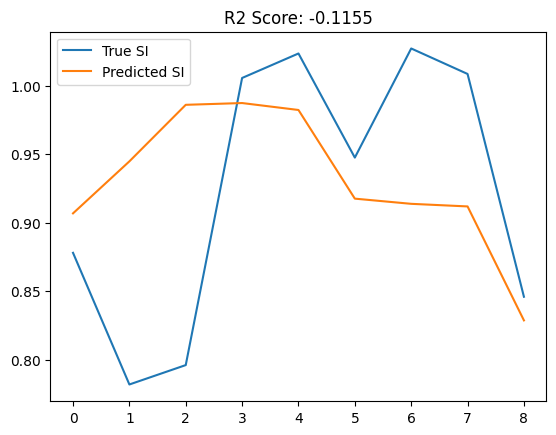

In [23]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# === Hyperparameters ===
seq_len = 10
n_features = 5
n_preds = 9
d_model = 64
nhead = 4
nlayers = 2
epochs = 50
batch_size = 64
lr = 0.001

# === Data Generation ===
def generate_sine_data(n_samples=1400):
    t = np.linspace(0, 20 * np.pi, n_samples)
    si = np.sin(t) + 0.1 * np.random.randn(n_samples)
    features = [si]  # first column is silicon
    for i in range(1, n_features):
        features.append(np.roll(si, i) + 0.05 * np.random.randn(n_samples))
    return pd.DataFrame(np.stack(features, axis=1), columns=[f'f{i}' for i in range(n_features)])

def make_dataset(df, seq_len):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len - n_preds):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+n_preds, 0])  # only predict SI
    return torch.stack(x), torch.stack(y)

# === Model ===
class TimeSeriesGPT(nn.Module):
    def __init__(self, n_features, d_model, nhead, nlayers, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.in_proj = nn.Linear(n_features, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, 1)  # predict 1 value per step

    def forward(self, x):  # x: [B, T, F]
        x = self.in_proj(x) + self.pos_emb[:, :x.size(1)]
        h = self.transformer(x)
        return self.out_proj(h).squeeze(-1)  # [B, T]

# === Scheduled Sampling Training ===
def train_model_with_scheduled_sampling():
    df = generate_sine_data()
    x, y = make_dataset(df, seq_len)
    x, y = x.to(device), y.to(device)
    loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)

    model = TimeSeriesGPT(n_features, d_model, nhead, nlayers, seq_len).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in loader:
            out = model(xb)[:, -n_preds:]  # use last n_preds steps
            loss = criterion(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    return model, df

# === Autoregressive Generation ===
def generate_future(model, start_seq, n_steps):
    model.eval()
    seq = start_seq.clone().detach().to(device)
    preds = []
    for _ in range(n_steps):
        with torch.no_grad():
            out = model(seq[:, -seq_len:])  # [B, seq_len]
            next_vec = out[:, -1:]  # last step
            next_feat = seq[:, -1:, :].clone()  # clone last full vector
            next_feat[:, :, 0] = next_vec  # replace SI
            seq = torch.cat((seq, next_feat), dim=1)  # append new step
            preds.append(next_vec.cpu().numpy())
    return np.concatenate(preds, axis=1).flatten()

# === Evaluation ===
def evaluate_and_plot(model, df):
    with torch.no_grad():
        start_idx = 1000
        start_seq = torch.tensor(df.values[start_idx:start_idx+seq_len][None], dtype=torch.float32).to(device)
        true_seq  = df.values[start_idx+seq_len:start_idx+seq_len+n_preds, 0]
        pred_seq  = generate_future(model, start_seq, n_preds)
        r2 = r2_score(true_seq, pred_seq)

        plt.plot(true_seq, label='True SI')
        plt.plot(pred_seq, label='Predicted SI')
        plt.title(f'R2 Score: {r2:.4f}')
        plt.legend()
        plt.show()

# === Run ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, df = train_model_with_scheduled_sampling()
evaluate_and_plot(model, df)




## other


Epoch 1 | Loss: 0.1132
Epoch 2 | Loss: 0.0150
Epoch 3 | Loss: 0.0069
Epoch 4 | Loss: 0.0051
Epoch 5 | Loss: 0.0045
Epoch 6 | Loss: 0.0037
Epoch 7 | Loss: 0.0034
Epoch 8 | Loss: 0.0029
Epoch 9 | Loss: 0.0025
Epoch 10 | Loss: 0.0024
Epoch 11 | Loss: 0.0021
Epoch 12 | Loss: 0.0019
Epoch 13 | Loss: 0.0017
Epoch 14 | Loss: 0.0016
Epoch 15 | Loss: 0.0015
Epoch 16 | Loss: 0.0014
Epoch 17 | Loss: 0.0013
Epoch 18 | Loss: 0.0012
Epoch 19 | Loss: 0.0012
Epoch 20 | Loss: 0.0011
Epoch 21 | Loss: 0.0011
Epoch 22 | Loss: 0.0010
Epoch 23 | Loss: 0.0010
Epoch 24 | Loss: 0.0010
Epoch 25 | Loss: 0.0009
Epoch 26 | Loss: 0.0009
Epoch 27 | Loss: 0.0009
Epoch 28 | Loss: 0.0008
Epoch 29 | Loss: 0.0008
Epoch 30 | Loss: 0.0008


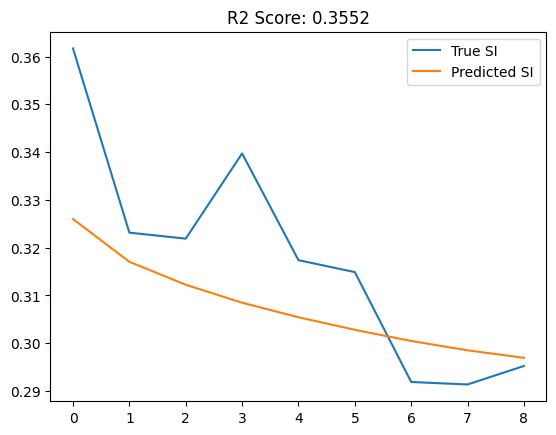

In [26]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import random

# ==== Device setup ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Generate Sine Dataset with Features ====
def generate_sine_df(N=1400, noise_std=0.01):
    t = np.linspace(0, 4 * np.pi, N)
    sine = np.sin(t)
    df = pd.DataFrame()
    df['target'] = sine + np.random.normal(0, noise_std, size=N)
    df['feat_lag'] = np.roll(sine, 1)
    df['feat_scaled'] = 1.5 * sine
    df['feat_cos'] = np.cos(t)
    df['feat_avg'] = 0.5 * (sine + np.roll(sine, 1))
    return df

# ==== Create Dataset ====
def make_dataset(df, seq_len=10):
    data = torch.tensor(df.values, dtype=torch.float32)
    x, y = [], []
    for i in range(len(data) - seq_len - 9):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+9, 0])  # Predict 9 future target values
    return torch.stack(x), torch.stack(y)

# ==== Transformer Model ====
class MiniGPT(nn.Module):
    def __init__(self, input_dim=5, emb_dim=64, num_heads=4, ff_dim=128, num_layers=2, seq_len=10):
        super().__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(emb_dim, 1)  # one-step prediction

    def forward(self, x):
        x = self.in_proj(x) + self.pos_emb[:, :x.size(1)]
        h = self.transformer(x)
        return self.out_proj(h[:, -1])  # only use final token for prediction

# ==== Training Loop with Scheduled Sampling ====
def train_model(model, x, y, num_epochs=20, ss_prob=0.5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loader = DataLoader(TensorDataset(x, y), batch_size=64, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0
        for xb, yb in loader:
            B = xb.size(0)
            inputs = xb.clone()
            preds = []

            # Scheduled Sampling
            for step in range(yb.size(1)):
                out = model(inputs)
                preds.append(out)
                use_truth = (random.random() > ss_prob)
                next_input = xb[:, -1].clone()  # last timestep
                next_input[:, 0] = yb[:, step] if use_truth else out.squeeze()
                inputs = torch.cat([inputs[:, 1:], next_input.unsqueeze(1)], dim=1)

            preds = torch.stack(preds, dim=1).squeeze(-1)
            loss = criterion(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")

# ==== Autoregressive Generation ====
def generate(model, seed_seq, steps=9):
    model.eval()
    preds = []
    current_seq = seed_seq.clone()
    for _ in range(steps):
        with torch.no_grad():
            out = model(current_seq.unsqueeze(0)).squeeze()
        preds.append(out.item())
        next_input = current_seq[-1].clone()
        next_input[0] = out
        current_seq = torch.cat([current_seq[1:], next_input.unsqueeze(0)], dim=0)
    return preds

# ==== Run Pipeline ====
df = generate_sine_df()
df = df.astype('float32')
x, y = make_dataset(df, seq_len=10)
x, y = x.to(device), y.to(device)

model = MiniGPT(input_dim=5, seq_len=10).to(device)
train_model(model, x, y, num_epochs=30, ss_prob=0.3)

# ==== Inference ====
seed_idx = 1000
seed_seq = x[seed_idx].cpu()
preds = generate(model, seed_seq, steps=9)
y_true = y[seed_idx].cpu().numpy()

# ==== Plot ==== 
plt.plot(y_true, label="True SI")
plt.plot(preds, label="Predicted SI")
plt.title(f"R2 Score: {r2_score(y_true, preds):.4f}")
plt.legend()
plt.show()




## Decoder only


Epoch 1/50, Loss: 0.0511
Epoch 2/50, Loss: 0.0178
Epoch 3/50, Loss: 0.0131
Epoch 4/50, Loss: 0.0118
Epoch 5/50, Loss: 0.0112
Epoch 6/50, Loss: 0.0109
Epoch 7/50, Loss: 0.0107
Epoch 8/50, Loss: 0.0106
Epoch 9/50, Loss: 0.0105
Epoch 10/50, Loss: 0.0104
Epoch 11/50, Loss: 0.0104
Epoch 12/50, Loss: 0.0103
Epoch 13/50, Loss: 0.0103
Epoch 14/50, Loss: 0.0102
Epoch 15/50, Loss: 0.0102
Epoch 16/50, Loss: 0.0102
Epoch 17/50, Loss: 0.0101
Epoch 18/50, Loss: 0.0101
Epoch 19/50, Loss: 0.0101
Epoch 20/50, Loss: 0.0101
Epoch 21/50, Loss: 0.0100
Epoch 22/50, Loss: 0.0100
Epoch 23/50, Loss: 0.0100
Epoch 24/50, Loss: 0.0100
Epoch 25/50, Loss: 0.0100
Epoch 26/50, Loss: 0.0100
Epoch 27/50, Loss: 0.0099
Epoch 28/50, Loss: 0.0099
Epoch 29/50, Loss: 0.0099
Epoch 30/50, Loss: 0.0099
Epoch 31/50, Loss: 0.0099
Epoch 32/50, Loss: 0.0099
Epoch 33/50, Loss: 0.0099
Epoch 34/50, Loss: 0.0099
Epoch 35/50, Loss: 0.0099
Epoch 36/50, Loss: 0.0099
Epoch 37/50, Loss: 0.0099
Epoch 38/50, Loss: 0.0099
Epoch 39/50, Loss: 0.

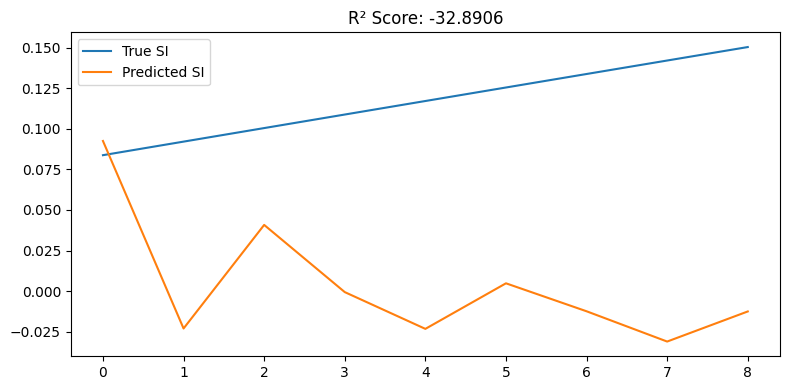

In [33]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ================== Synthetic Data Generation ==================
def generate_synthetic_data(num_points=1500, vec_size=35, si_index=2):
    t = np.linspace(0, 4 * np.pi, num_points)
    si = np.sin(t)
    data = np.random.randn(num_points, vec_size) * 0.1
    data[:, si_index] = si
    return torch.tensor(data, dtype=torch.float32)

# ================== Dataset Prep ==================
def make_dataset(data, seq_len=10, pred_len=9):
    x, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        x.append(data[i:i + seq_len])
        y.append(data[i + seq_len:i + seq_len + pred_len])
    return torch.stack(x), torch.stack(y)

# ================== Decoder GPT Model ==================
class DecoderGPT(nn.Module):
    def __init__(self, input_dim, emb_dim=64, nhead=4, num_layers=2, dropout=0.1, max_seq=100):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_seq, emb_dim))
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)

    def forward(self, src, tgt):
        src = self.in_proj(src) + self.pos_emb[:, :src.size(1)]
        tgt = self.in_proj(tgt) + self.pos_emb[:, :tgt.size(1)]
        output = self.decoder(tgt, src)
        return self.out_proj(output)

# ================== Scheduled Sampling Helper ==================
def scheduled_sample(true, pred, p):
    mask = torch.rand_like(torch.ones(true.shape[0])) < p
    mask = mask.to(true.device).float().view(-1, 1, 1)
    return mask * true + (1 - mask) * pred

# ================== Training Function ==================
def train_model(model, x, y, device, num_epochs=50, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loader = DataLoader(TensorDataset(x, y), batch_size=32, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            pred_seq = []
            prev = xb[:, -1:]  # last step as first input
            for t in range(yb.size(1)):
                out = model(xb, prev)
                next_step = out[:, -1:]
                pred_seq.append(next_step)
                teacher = yb[:, t:t+1]
                p = 1.0 - epoch / num_epochs
                mixed = scheduled_sample(teacher, next_step.detach(), p)
                prev = torch.cat([prev, mixed], dim=1)

            preds = torch.cat(pred_seq, dim=1)
            loss = loss_fn(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.4f}")

# ================== Generation Function ==================
@torch.no_grad()
def generate_autoregressive(model, x_init, pred_len=9):
    model.eval()
    preds = []
    prev = x_init.clone()
    for _ in range(pred_len):
        out = model(x_init, prev)
        next_step = out[:, -1:]
        preds.append(next_step)
        prev = torch.cat([prev, next_step], dim=1)
    return torch.cat(preds, dim=1)

# ================== Plotting Function ==================
def plot_results(y_true, y_pred, si_index=2):
    true_si = y_true[:, :, si_index].flatten().cpu().numpy()
    pred_si = y_pred[:, :, si_index].flatten().cpu().numpy()
    r2 = r2_score(true_si, pred_si)
    plt.figure(figsize=(8, 4))
    plt.plot(true_si, label='True SI')
    plt.plot(pred_si, label='Predicted SI')
    plt.title(f"R² Score: {r2:.4f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================== Main Execution ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate and prepare data
data = generate_synthetic_data()
x, y = make_dataset(data)
x, y = x.to(device), y.to(device)

# Model
model = DecoderGPT(input_dim=35, max_seq=20).to(device)
train_model(model, x, y, device)

# Generate and evaluate
x_init = x[:1]  # take first sample for demo
y_true = y[:1]
y_pred = generate_autoregressive(model, x_init)
plot_results(y_true, y_pred)




## other


Epoch 0, Loss: 0.5561
Epoch 10, Loss: 0.0770
Epoch 20, Loss: 0.0501
Epoch 30, Loss: 0.0286
Epoch 40, Loss: 0.0254


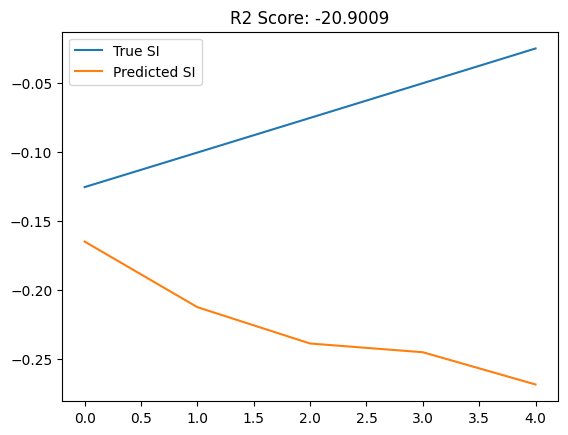

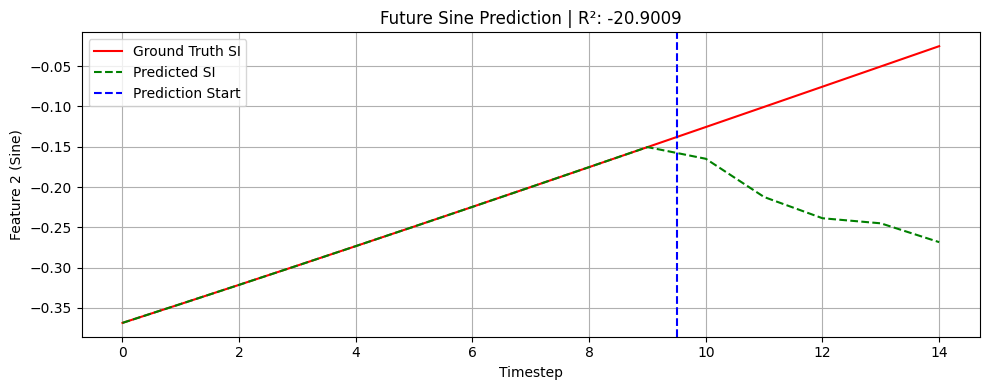

In [34]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ===== Toy Sine Dataset =====
def generate_data(n_samples=1000, n_features=8):
    t = np.linspace(0, 8*np.pi, n_samples)
    sine_wave = np.sin(t)
    data = np.random.randn(n_samples, n_features) * 0.1
    data[:, 2] = sine_wave
    return torch.tensor(data, dtype=torch.float32)

def create_sequences(data, seq_len=10, pred_len=5):
    x, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return torch.stack(x), torch.stack(y)

# ===== Decoder-Only GPT Model =====
class DecoderGPT(nn.Module):
    def __init__(self, input_dim=8, emb_dim=32, n_heads=4, n_layers=2, max_len=15):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        block = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(block, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)

    def forward(self, context, tgt):
        context = self.in_proj(context) + self.pos_emb[:, :context.size(1)]
        tgt = self.in_proj(tgt) + self.pos_emb[:, :tgt.size(1)]
        mask = torch.triu(torch.ones(tgt.size(1), tgt.size(1)), diagonal=1).bool()
        out = self.decoder(tgt, context, tgt_mask=mask)
        return self.out_proj(out)

# ===== Evaluation Plot =====
def plot_preds(true, pred):
    y_true = true[:, :, 2].flatten().numpy()
    y_pred = pred[:, :, 2].detach().numpy().flatten()
    plt.plot(y_true, label="True SI")
    plt.plot(y_pred, label="Predicted SI")
    plt.title(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    plt.legend()
    plt.show()

# ===== Run Everything =====
data = generate_data()
x, y = create_sequences(data)
x_train, y_train = x[:-1], y[:-1]
x_test, y_test = x[-1:], y[-1:]

model = DecoderGPT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training with teacher forcing
for epoch in range(50):
    model.train()
    tgt_input = torch.cat([x_train[:, -1:], y_train[:, :-1]], dim=1)
    out = model(x_train, tgt_input)
    loss = loss_fn(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Autoregressive generation
model.eval()
tgt = x_test[:, -1:].clone()
generated = []
for _ in range(y_test.size(1)):
    out = model(x_test, tgt)
    next_token = out[:, -1:]
    generated.append(next_token)
    tgt = torch.cat([tgt, next_token], dim=1)

pred = torch.cat(generated, dim=1)
plot_preds(y_test, pred)


def plot_preds(true, pred, input_context):
    plt.figure(figsize=(10, 4))
    
    # Feature 2 = sine wave
    context_si = input_context[:, :, 2].flatten().numpy()
    true_si = true[:, :, 2].flatten().numpy()
    pred_si = pred[:, :, 2].detach().numpy().flatten()
    
    full_true = np.concatenate([context_si, true_si])
    full_pred = np.concatenate([context_si, pred_si])
    
    x = np.arange(len(full_true))
    divide = len(context_si)

    plt.plot(x, full_true, label="Ground Truth SI", color='red')
    plt.plot(x, full_pred, label="Predicted SI", color='green', linestyle='--')
    plt.axvline(x=divide - 0.5, color='blue', linestyle='--', label="Prediction Start")
    
    plt.title(f"Future Sine Prediction | R²: {r2_score(true_si, pred_si):.4f}")
    plt.xlabel("Timestep")
    plt.ylabel("Feature 2 (Sine)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
plot_preds(y_test, pred, x_test)




## other


Epoch 0, Loss: 0.6312
Epoch 10, Loss: 0.0953
Epoch 20, Loss: 0.0358
Epoch 30, Loss: 0.0192
Epoch 40, Loss: 0.0173


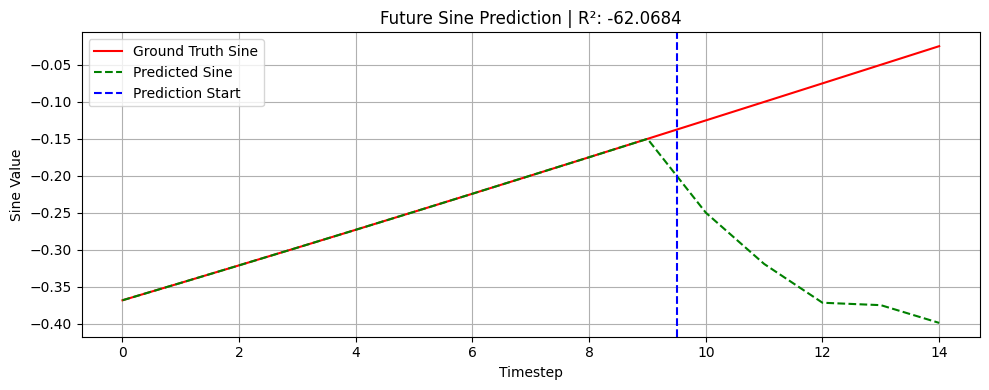

In [40]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ===== Toy Sine Dataset =====
def generate_data(n_samples=1000):
    t = np.linspace(0, 8 * np.pi, n_samples)
    sine_wave = np.sin(t)
    data = sine_wave.reshape(-1, 1)  # shape [n_samples, 1]
    return torch.tensor(data, dtype=torch.float32)

def create_sequences(data, seq_len=10, pred_len=5):
    x, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return torch.stack(x), torch.stack(y)  # [N, seq, 1]

# ===== Decoder-Only GPT Model =====
class DecoderGPT(nn.Module):
    def __init__(self, input_dim=1, emb_dim=32, n_heads=4, n_layers=2, max_len=15):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        block = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(block, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)

    def forward(self, context, tgt):
        context = self.in_proj(context) + self.pos_emb[:, :context.size(1)]
        tgt = self.in_proj(tgt) + self.pos_emb[:, :tgt.size(1)]
        mask = torch.triu(torch.ones(tgt.size(1), tgt.size(1)), diagonal=1).bool().to(tgt.device)
        out = self.decoder(tgt, context, tgt_mask=mask)
        return self.out_proj(out)

# ===== Evaluation Plot =====
def plot_preds(true, pred, input_context):
    plt.figure(figsize=(10, 4))

    context_si = input_context[:, :, 0].flatten().numpy()
    true_si = true[:, :, 0].flatten().numpy()
    pred_si = pred[:, :, 0].detach().numpy().flatten()

    full_true = np.concatenate([context_si, true_si])
    full_pred = np.concatenate([context_si, pred_si])

    x = np.arange(len(full_true))
    divide = len(context_si)

    plt.plot(x, full_true, label="Ground Truth Sine", color='red')
    plt.plot(x, full_pred, label="Predicted Sine", color='green', linestyle='--')
    plt.axvline(x=divide - 0.5, color='blue', linestyle='--', label="Prediction Start")

    plt.title(f"Future Sine Prediction | R²: {r2_score(true_si, pred_si):.4f}")
    plt.xlabel("Timestep")
    plt.ylabel("Sine Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== Run Everything =====
data = generate_data()
x, y = create_sequences(data)
x_train, y_train = x[:-1], y[:-1]
x_test, y_test = x[-1:], y[-1:]

model = DecoderGPT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training with teacher forcing
for epoch in range(50):
    model.train()
    tgt_input = torch.cat([x_train[:, -1:], y_train[:, :-1]], dim=1)
    out = model(x_train, tgt_input)
    loss = loss_fn(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Autoregressive generation
model.eval()
tgt = x_test[:, -1:].clone()
generated = []
for _ in range(y_test.size(1)):
    out = model(x_test, tgt)
    next_token = out[:, -1:]
    generated.append(next_token)
    tgt = torch.cat([tgt, next_token], dim=1)

pred = torch.cat(generated, dim=1)
plot_preds(y_test, pred, x_test)




## other


In [41]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ===== Sine Dataset with Amplitude + Phase Variation =====
def generate_data(n_samples=1000):
    t = np.linspace(0, 8 * np.pi, n_samples)
    phase = np.random.rand() * 2 * np.pi
    amp = 0.5 + np.random.rand() * 1.5
    sine_wave = amp * np.sin(t + phase)
    return torch.tensor(sine_wave.reshape(-1, 1), dtype=torch.float32)

def create_sequences(data, seq_len=10, pred_len=5):
    x, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return torch.stack(x), torch.stack(y)

# ===== Decoder-Only GPT Model =====
class DecoderGPT(nn.Module):
    def __init__(self, input_dim=1, emb_dim=32, n_heads=4, n_layers=2, max_len=15):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        block = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(block, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)

    def forward(self, context, tgt):
        context = self.in_proj(context) + self.pos_emb[:, :context.size(1)]
        tgt = self.in_proj(tgt) + self.pos_emb[:, :tgt.size(1)]
        mask = torch.triu(torch.ones(tgt.size(1), tgt.size(1)), diagonal=1).bool().to(tgt.device)
        out = self.decoder(tgt, context, tgt_mask=mask)
        return self.out_proj(out)

# ===== Plotting Function =====
def plot_preds(true, pred, input_context):
    plt.figure(figsize=(10, 4))
    context_si = input_context[:, :, 0].flatten().numpy()
    true_si = true[:, :, 0].flatten().numpy()
    pred_si = pred[:, :, 0].detach().numpy().flatten()

    full_true = np.concatenate([context_si, true_si])
    full_pred = np.concatenate([context_si, pred_si])
    x = np.arange(len(full_true))
    divide = len(context_si)

    plt.plot(x, full_true, label="Ground Truth Sine", color='red')
    plt.plot(x, full_pred, label="Predicted Sine", color='green', linestyle='--')
    plt.axvline(x=divide - 0.5, color='blue', linestyle='--', label="Prediction Start")
    plt.title(f"Future Sine Prediction | R²: {r2_score(true_si, pred_si):.4f}")
    plt.xlabel("Timestep")
    plt.ylabel("Sine Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== Training Setup =====
SEQ_LEN = 10
PRED_LEN = 5
EPOCHS = 300
SCHEDULED_SAMPLING_PROB = 0.5

data = generate_data()
x, y = create_sequences(data)
x_train, y_train = x[:-1], y[:-1]
x_test, y_test = x[-1:], y[-1:]

model = DecoderGPT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===== Training with Scheduled Sampling =====
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for i in range(x_train.size(0)):
        context = x_train[i:i+1]             # [1, 10, 1]
        target = y_train[i:i+1]              # [1, 5, 1]
        tgt_input = context[:, -1:]          # seed decoder input

        # Scheduled sampling loop
        generated = []
        for step in range(PRED_LEN):
            out = model(context, tgt_input)
            next_pred = out[:, -1:]          # latest prediction

            use_model = np.random.rand() < SCHEDULED_SAMPLING_PROB
            next_in = next_pred if use_model else target[:, step:step+1]
            tgt_input = torch.cat([tgt_input, next_in], dim=1)
            generated.append(next_pred)

        pred = torch.cat(generated, dim=1)   # [1, 5, 1]
        loss = loss_fn(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Avg Loss: {total_loss / x_train.size(0):.4f}")

# ===== Autoregressive Prediction on Test =====
model.eval()
tgt = x_test[:, -1:].clone()
generated = []
for _ in range(y_test.size(1)):
    out = model(x_test, tgt)
    next_token = out[:, -1:]
    generated.append(next_token)
    tgt = torch.cat([tgt, next_token], dim=1)

pred = torch.cat(generated, dim=1)
plot_preds(y_test, pred, x_test)



Epoch 0, Avg Loss: 0.0145
Epoch 50, Avg Loss: 0.0609


KeyboardInterrupt: 


## other


Epoch 0, Loss: 7.845092
Epoch 50, Loss: 0.087074
Epoch 100, Loss: 0.031182
Epoch 150, Loss: 0.022929
Epoch 200, Loss: 0.018123
Epoch 250, Loss: 0.015273


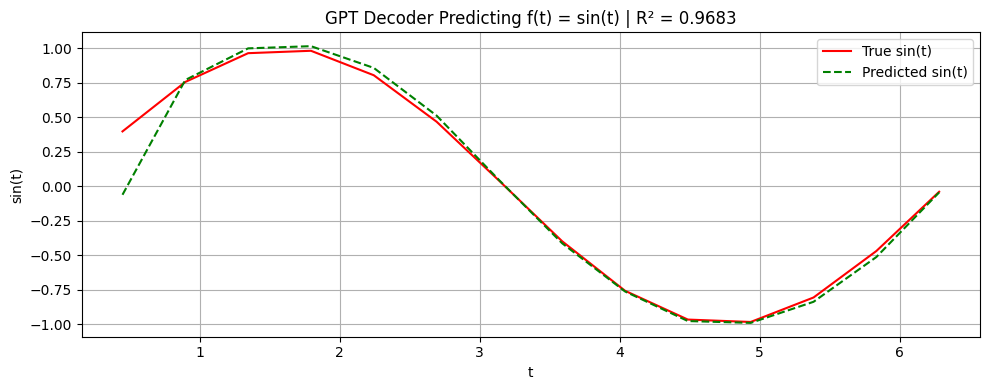

In [42]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ========== Generate Data ==========
def generate_sine_data(seq_len=14, total_samples=500):
    samples = []
    for _ in range(total_samples):
        phase = np.random.rand() * 2 * np.pi
        t = np.linspace(0, 2 * np.pi, seq_len + 1)
        y = np.sin(t + phase)
        sample = np.stack([t, y], axis=1)  # shape: [seq_len+1, 2]
        samples.append(sample)
    return torch.tensor(np.stack(samples), dtype=torch.float32)

# ========== GPT Decoder Model ==========
class GPTTimeModel(nn.Module):
    def __init__(self, input_dim=2, emb_dim=64, n_heads=4, n_layers=2, max_len=32):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        block = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(block, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, 2)

    def forward(self, x):
        B, T, _ = x.shape
        x = self.in_proj(x) + self.pos_emb[:, :T]
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(x.device)
        x = self.transformer(x, mask=mask)
        return self.out_proj(x)

# ========== Training Setup ==========
SEQ_LEN = 14
data = generate_sine_data(seq_len=SEQ_LEN, total_samples=500)

x = data[:, :-1, :]   # shape: [B, 14, 2]
y = data[:, 1:, :]    # shape: [B, 14, 2]

x_train, y_train = x[:-10], y[:-10]
x_test, y_test = x[-1:], y[-1:]

model = GPTTimeModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ========== Training ==========
for epoch in range(300):
    model.train()
    out = model(x_train)
    loss = loss_fn(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ========== Evaluation ==========
model.eval()
with torch.no_grad():
    pred = model(x_test)  # [1, 14, 2]
    true = y_test         # [1, 14, 2]

    pred_sin = pred[0, :, 1].numpy()
    true_sin = true[0, :, 1].numpy()
    t_axis = true[0, :, 0].numpy()

    r2 = r2_score(true_sin, pred_sin)

    plt.figure(figsize=(10, 4))
    plt.plot(t_axis, true_sin, label="True sin(t)", color='red')
    plt.plot(t_axis, pred_sin, label="Predicted sin(t)", color='green', linestyle='--')
    plt.title(f"GPT Decoder Predicting f(t) = sin(t) | R² = {r2:.4f}")
    plt.xlabel("t")
    plt.ylabel("sin(t)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




## other (this may be important)


Epoch 0, Loss: 7.220187
Epoch 50, Loss: 0.105237
Epoch 100, Loss: 0.028438
Epoch 150, Loss: 0.019376
Epoch 200, Loss: 0.014170
Epoch 250, Loss: 0.011506


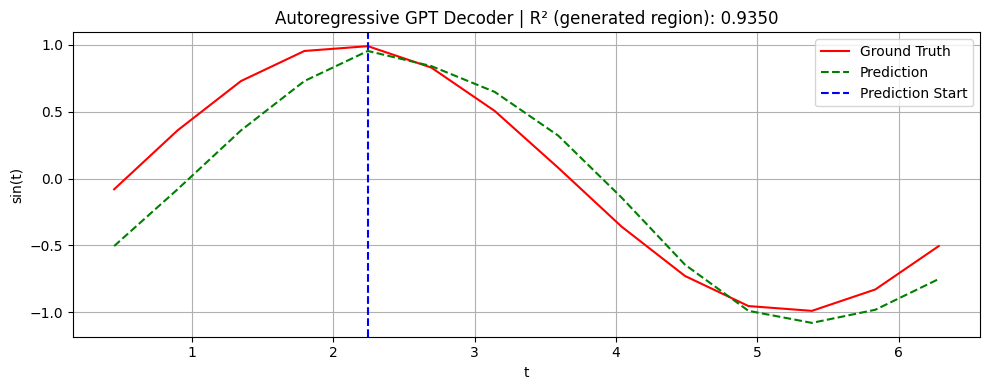

In [44]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ========== Generate Data ==========
def generate_sine_data(seq_len=14, total_samples=500):
    samples = []
    for _ in range(total_samples):
        phase = np.random.rand() * 2 * np.pi
        t = np.linspace(0, 2 * np.pi, seq_len + 1)
        y = np.sin(t + phase)
        sample = np.stack([t, y], axis=1)  # shape: [seq_len+1, 2]
        samples.append(sample)
    return torch.tensor(np.stack(samples), dtype=torch.float32)

# ========== Decoder-Only GPT Model ==========
class DecoderOnlyGPT(nn.Module):
    def __init__(self, input_dim=2, emb_dim=64, n_heads=4, n_layers=2, max_len=32):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        block = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(block, num_layers=n_layers)
        self.out_proj = nn.Linear(emb_dim, input_dim)

    def forward(self, tgt):
        B, T, _ = tgt.size()
        x = self.in_proj(tgt) + self.pos_emb[:, :T]
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(tgt.device)
        out = self.decoder(x, x, tgt_mask=mask)
        return self.out_proj(out)

# ========== Setup ==========
SEQ_LEN = 14
data = generate_sine_data(seq_len=SEQ_LEN, total_samples=500)
x = data[:, :-1, :]  # [B, 14, 2]
y = data[:, 1:, :]   # [B, 14, 2]

x_train, y_train = x[:-10], y[:-10]
x_test, y_test = x[-1:], y[-1:]

model = DecoderOnlyGPT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ========== Training ==========
for epoch in range(300):
    model.train()
    out = model(x_train)
    loss = loss_fn(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ========== Autoregressive Generation ==========
model.eval()
with torch.no_grad():
    context = x_test[:, :5, :]  # start with first 5 tokens
    generated = [context]

    for _ in range(SEQ_LEN - 5):
        tgt = torch.cat(generated, dim=1)
        out = model(tgt)
        next_token = out[:, -1:, :]  # latest output
        generated.append(next_token)

    pred_sequence = torch.cat(generated, dim=1)  # [1, 14, 2]
    true_sequence = y_test  # [1, 14, 2]

    # Align t and sin(t)
    pred_sin = pred_sequence[0, :, 1].cpu().numpy()
    true_sin = true_sequence[0, :, 1].cpu().numpy()
    input_sin = context[0, :, 1].cpu().numpy()
    t_axis = true_sequence[0, :, 0].cpu().numpy()
    input_len = context.shape[1]

    ## r2 = r2_score(true_sin, pred_sin[input_len:])
    r2 = r2_score(true_sin[input_len:], pred_sin[input_len:])

# ========== Plot ==========
plt.figure(figsize=(10, 4))
x_all = t_axis
gt_all = true_sin
pred_all = pred_sin

plt.plot(x_all, gt_all, color='red', label='Ground Truth')
plt.plot(x_all, pred_all, color='green', linestyle='--', label='Prediction')
plt.axvline(x=t_axis[input_len - 1], color='blue', linestyle='--', label='Prediction Start')

plt.title(f"Autoregressive GPT Decoder | R² (generated region): {r2:.4f}")
plt.xlabel("t")
plt.ylabel("sin(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




## kutz 


Epoch 0, Loss: 1.317387
Epoch 50, Loss: 0.940942
Epoch 100, Loss: 0.900760
Epoch 150, Loss: 0.871374
Epoch 200, Loss: 0.884259
Epoch 250, Loss: 0.819961
R² score on Feature 2 (sine): -0.2109


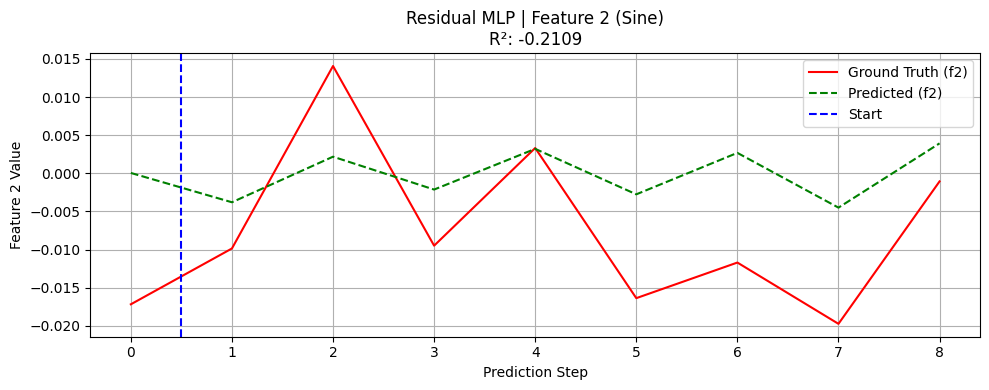

In [47]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ========== Step 1: Generate Dummy Data ==========
np.random.seed(0)
N = 1000       # time steps
D = 35         # feature dimensions
SEQ_IN = 10    # how many steps in
SEQ_OUT = 9    # how many to predict

t = np.linspace(0, 10 * np.pi, N)
sine_feature = np.sin(t)

# Make sine feature dominant
data = np.random.randn(N, D) * 0.01
data[:, 2] = sine_feature

# Add time as feature 0
t_norm = np.linspace(0, 1, N).reshape(-1, 1)
data_with_time = np.concatenate([t_norm, data], axis=1)  # shape [N, 36]

# ========== Step 2: Prepare Sequences ==========
def create_sequences(data, seq_in, seq_out):
    X, Y = [], []
    for i in range(len(data) - seq_in - seq_out):
        X.append(data[i:i+seq_in])
        Y.append(data[i+seq_in:i+seq_in+seq_out])
    return torch.tensor(np.stack(X), dtype=torch.float32), torch.tensor(np.stack(Y), dtype=torch.float32)

X, Y = create_sequences(data_with_time, SEQ_IN, SEQ_OUT)  # [B, 10, 36], [B, 9, 36]

# Normalize
X_mean = X.mean((0, 1))
X_std = X.std((0, 1)) + 1e-6
X_norm = (X - X_mean) / X_std
Y_norm = (Y - X_mean) / X_std

# ========== Step 3: Residual MLP ==========
class ResidualMLP(nn.Module):
    def __init__(self, input_dim=36, hidden=128, output_dim=36):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, output_dim)
        )
        self.res_proj = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x):
        return self.net(x) + self.res_proj(x)

model = ResidualMLP()

# ========== Step 4: Train Model for Multi-step Prediction ==========
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

BATCH = 64
EPOCHS = 300
for epoch in range(EPOCHS):
    idx = np.random.permutation(len(X_norm))
    for i in range(0, len(X_norm), BATCH):
        xb = X_norm[idx[i:i+BATCH]]       # [B, 10, 36]
        yb = Y_norm[idx[i:i+BATCH]]       # [B, 9, 36]

        preds = []
        input_step = xb[:, -1, :]         # start from last input frame

        for step in range(SEQ_OUT):
            next_step = model(input_step)           # [B, 36]
            preds.append(next_step.unsqueeze(1))    # [B, 1, 36]
            input_step = next_step                  # feed back

        out_seq = torch.cat(preds, dim=1)  # [B, 9, 36]
        loss = loss_fn(out_seq, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ========== Step 5: Rollout and Plot ==========
with torch.no_grad():
    start = 500
    input_seq = X_norm[start:start+1]           # [1, 10, 36]
    input_step = input_seq[:, -1, :]            # last vector [1, 36]
    preds = []

    for _ in range(SEQ_OUT):
        next_step = model(input_step)
        preds.append(next_step)
        input_step = next_step

    pred_tensor = torch.stack(preds, dim=1)         # [1, 9, 36]
    gt_tensor = Y_norm[start:start+1]               # [1, 9, 36]

    # Unnormalize
    pred_un = pred_tensor[0] * X_std + X_mean
    gt_un = gt_tensor[0] * X_std + X_mean

# ========== Step 6: Plot Feature 2 ==========
pred_si = pred_un[:, 2].numpy()
true_si = gt_un[:, 2].numpy()

r2 = r2_score(true_si, pred_si)
print(f"R² score on Feature 2 (sine): {r2:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(true_si, label="Ground Truth (f2)", color='red')
plt.plot(pred_si, label="Predicted (f2)", linestyle='--', color='green')
plt.axvline(x=0.5, color='blue', linestyle='--', label='Start')
plt.title(f"Residual MLP | Feature 2 (Sine)\nR²: {r2:.4f}")
plt.xlabel("Prediction Step")
plt.ylabel("Feature 2 Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

